In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import sys
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import get_scheduler

In [3]:
!pip install pytorch-crf

In [ ]:
# Add the project root to Python path for imports
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned"
sys.path.append(PROJECT_DIR)

from dataset.dataset_es import get_dataloaders
from Models.xlm_roberta_improved import XLMRobertaForIdiomDetection, predict_idioms, evaluate

# Define paths
DATA_DIR = os.path.join(PROJECT_DIR, "dataset")
MODELS_DIR = os.path.join(PROJECT_DIR, "Models")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "Submissions")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "Models/saved_models"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "Models/results"), exist_ok=True)

In [5]:
def run_organized_experiment(batch_size=16, lr=1e-5, max_length=128, epochs=3):
    experiment_name = f"xlm_bs{batch_size}_lr{lr}_ml{max_length}_ep{epochs}"
    model_save_path = os.path.join(PROJECT_DIR, "Models/saved_models", f"{experiment_name}.pt")
    results_save_path = os.path.join(PROJECT_DIR, "Models/results", f"{experiment_name}_metrics.csv")
    fig_save_path = os.path.join(PROJECT_DIR, "Models/results", f"{experiment_name}_plot.png")

    # Initialize results
    results = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    # Initialize tokenizer
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

    print(f"\nRunning experiment: {experiment_name}")
    print("Loading data...")

    # Get data loaders from dataset.py
    train_loader, val_loader, _ = get_dataloaders(
        train_path=os.path.join(DATA_DIR, 'train.csv'),
        val_path=os.path.join(DATA_DIR, 'eval.csv'),
        batch_size=batch_size,
        max_length=max_length,
        tokenizer=tokenizer
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = XLMRobertaForIdiomDetection()
    model.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    best_f1 = 0.0
    best_epoch = 0

    # Added these line to control earlystopping
    patience = 2
    no_improve_epochs = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for batch in progress_bar:
            if batch['input_ids'].size(0) == 0:
                continue

            train_batches += 1
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_train_loss = train_loss / train_batches if train_batches > 0 else 0
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Evaluation
        print("Evaluating...")
        metrics = evaluate(model, val_loader, tokenizer, device)

        # Store metrics
        results['epoch'].append(epoch + 1)
        results['train_loss'].append(avg_train_loss)
        results['val_loss'].append(metrics['val_loss'])
        results['precision'].append(metrics['precision'])
        results['recall'].append(metrics['recall'])
        results['f1'].append(metrics['f1'])

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {metrics['val_loss']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1 Score: {metrics['f1']:.4f}")

        # Early stopping logic
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_epoch = epoch + 1
            no_improve_epochs = 0
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with F1: {best_f1:.4f}")
        else:
            no_improve_epochs += 1
            print(f"No improvement in F1 for {no_improve_epochs} epoch(s).")

            if no_improve_epochs >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    # Save metrics to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(results_save_path, index=False)
    print(f"Results saved to {results_save_path}")

    # Plot results
    plt.figure(figsize=(12, 10))

    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(results['epoch'], results['train_loss'], 'b-', marker='o', label='Training Loss')
    plt.plot(results['epoch'], results['val_loss'], 'r-', marker='o', label='Validation Loss')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot metrics
    plt.subplot(2, 1, 2)
    plt.plot(results['epoch'], results['precision'], 'g-', marker='o', label='Precision')
    plt.plot(results['epoch'], results['recall'], 'b-', marker='o', label='Recall')
    plt.plot(results['epoch'], results['f1'], 'r-', marker='o', label='F1 Score')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    plt.title('Model Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(fig_save_path)
    print(f"Plot saved to {fig_save_path}")
    plt.show()

    # Load best model for predictions
    best_model = XLMRobertaForIdiomDetection(model_name="xlm-roberta-large", num_labels=3)
    best_model.load_state_dict(torch.load(model_save_path))
    best_model.to(device)

    # Make predictions
    prediction_file = os.path.join(PROJECT_DIR, "Models/results", f"{experiment_name}_predictions.csv")
    generate_predictions(best_model, tokenizer, device, prediction_file)

    return {
        'model_path': model_save_path,
        'results_path': results_save_path,
        'fig_path': fig_save_path,
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'final_metrics': {
            'precision': results['precision'][-1],
            'recall': results['recall'][-1],
            'f1': results['f1'][-1]
        }
    }


In [6]:
def generate_predictions(model, tokenizer, device, output_file):
    print("Generating predictions...")
    model.eval()

    # Read test data
    test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_w_o_labels.csv'))
    ids = test_df['id'].tolist()
    languages = test_df['language'].tolist()
    sentences = test_df['sentence'].tolist()

    # Generate predictions
    results = []
    for idx, sentence, lang in tqdm(zip(ids, sentences, languages), total=len(ids)):
        _, idiom_indices = predict_idioms(model, tokenizer, sentence, device)
        # If no idiom, output [-1] as in training
        if not idiom_indices:
            idiom_indices = [-1]
        results.append({'id': idx, 'indices': str(idiom_indices), 'language': lang})

    # Save predictions
    out_df = pd.DataFrame(results)
    out_df.to_csv(output_file, index=False)
    print(f'Predictions saved to {output_file}')

    return out_df


Running experiment: xlm_bs16_lr3e-05_ml128_ep15
Loading data...


Epoch 1/15 [Training]: 100%|██████████| 720/720 [09:29<00:00,  1.26it/s, loss=3.3083]


Average training loss: 5.7237
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:30<00:00,  2.91it/s]


Epoch 1/15:
  Train Loss: 5.7237
  Val Loss: 2.7993
  Precision: 0.4358
  Recall: 0.4444
  F1 Score: 0.4326
New best model saved with F1: 0.4326


Epoch 2/15 [Training]: 100%|██████████| 720/720 [09:31<00:00,  1.26it/s, loss=1.7791]


Average training loss: 2.7157
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:31<00:00,  2.90it/s]


Epoch 2/15:
  Train Loss: 2.7157
  Val Loss: 1.9921
  Precision: 0.4211
  Recall: 0.4109
  F1 Score: 0.4116
No improvement in F1 for 1 epoch(s).


Epoch 3/15 [Training]: 100%|██████████| 720/720 [09:31<00:00,  1.26it/s, loss=1.9716]


Average training loss: 1.8954
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:31<00:00,  2.88it/s]


Epoch 3/15:
  Train Loss: 1.8954
  Val Loss: 1.9020
  Precision: 0.4830
  Recall: 0.4891
  F1 Score: 0.4837
New best model saved with F1: 0.4837


Epoch 4/15 [Training]: 100%|██████████| 720/720 [09:31<00:00,  1.26it/s, loss=0.3203]


Average training loss: 1.5215
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:30<00:00,  2.90it/s]


Epoch 4/15:
  Train Loss: 1.5215
  Val Loss: 1.3229
  Precision: 0.4661
  Recall: 0.4642
  F1 Score: 0.4634
No improvement in F1 for 1 epoch(s).


Epoch 5/15 [Training]: 100%|██████████| 720/720 [09:31<00:00,  1.26it/s, loss=7.8775]


Average training loss: 1.3050
Evaluating...


Evaluating: 100%|██████████| 90/90 [00:31<00:00,  2.89it/s]


Epoch 5/15:
  Train Loss: 1.3050
  Val Loss: 1.9404
  Precision: 0.4579
  Recall: 0.4567
  F1 Score: 0.4562
No improvement in F1 for 2 epoch(s).
Early stopping triggered after 5 epochs.
Results saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/xlm_bs16_lr3e-05_ml128_ep15_metrics.csv
Plot saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/xlm_bs16_lr3e-05_ml128_ep15_plot.png


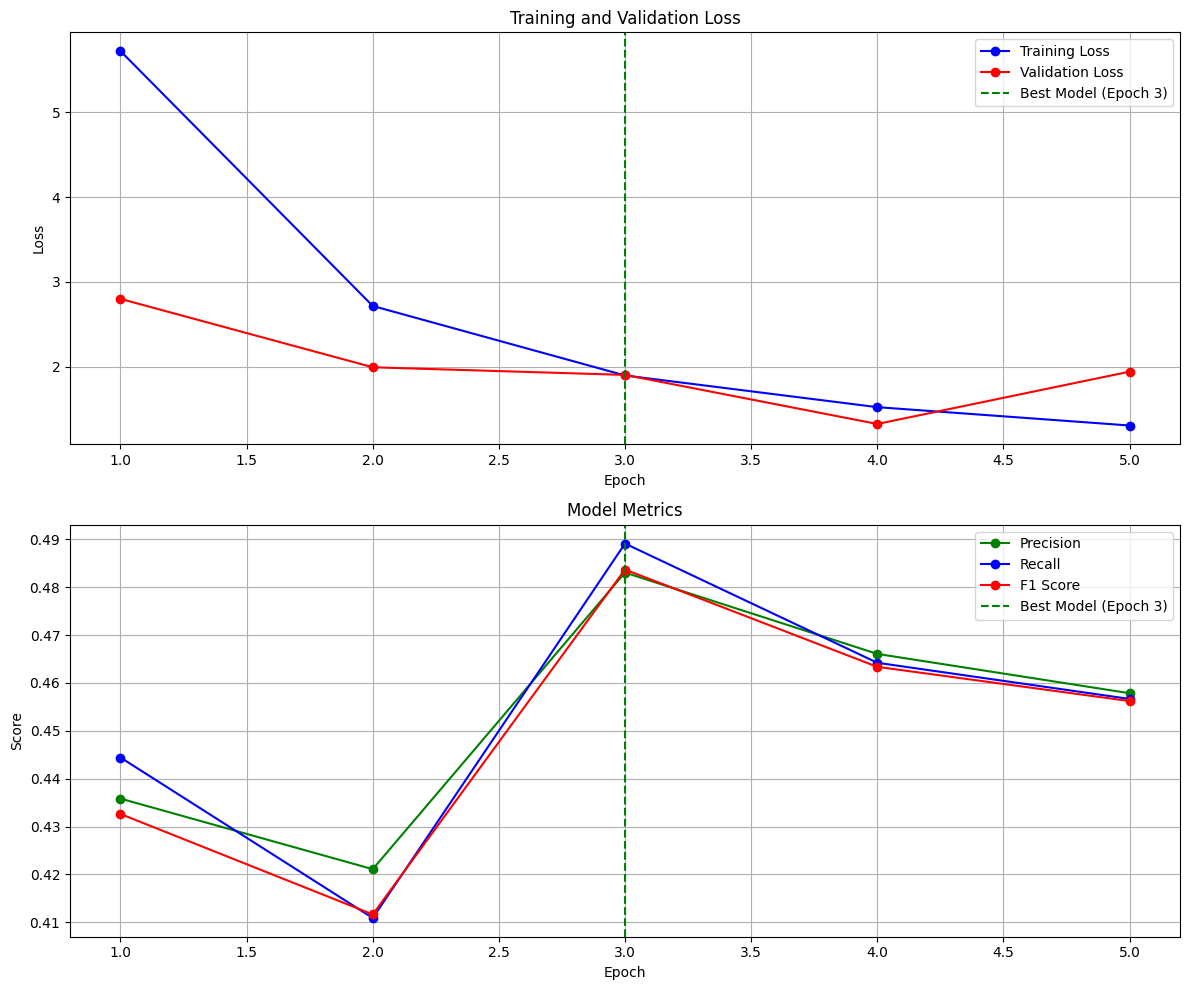

Generating predictions...


100%|██████████| 1435/1435 [00:56<00:00, 25.51it/s]


Predictions saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/xlm_bs16_lr3e-05_ml128_ep15_predictions.csv

Experiment complete!
Best F1 Score: 0.4837 (Epoch 3)
Model saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/saved_models/xlm_bs16_lr3e-05_ml128_ep15.pt
Metrics saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/xlm_bs16_lr3e-05_ml128_ep15_metrics.csv
Plot saved to: /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/xlm_bs16_lr3e-05_ml128_ep15_plot.png


In [8]:
# Run a single experiment with desired parameters
result = run_organized_experiment(batch_size=16, lr=3e-05, max_length=128, epochs=15)

print("\nExperiment complete!")
print(f"Best F1 Score: {result['best_f1']:.4f} (Epoch {result['best_epoch']})")
print(f"Model saved to: {result['model_path']}")
print(f"Metrics saved to: {result['results_path']}")
print(f"Plot saved to: {result['fig_path']}")

# If you want to make prediction from saved model

In [9]:
import os
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/saved_models/xlm_bs16_lr3e-05_ml128_ep15.pt"
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/dataset"
OUTPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/predictions.csv"

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

# Load your model class from the Python file
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models")

from xlm_roberta_improved import XLMRobertaForIdiomDetection, predict_idioms

# Instantiate the model and load weights
model = XLMRobertaForIdiomDetection(model_name="xlm-roberta-large", num_labels=3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

def generate_predictions(model, tokenizer, device, output_file):
    print("Generating predictions...")
    model.eval()

    # Read test data
    test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_w_o_labels.csv'))
    ids = test_df['id'].tolist()
    languages = test_df['language'].tolist()
    sentences = test_df['sentence'].tolist()

    # Generate predictions
    results = []
    for idx, sentence, lang in tqdm(zip(ids, sentences, languages), total=len(ids)):
        _, idiom_indices = predict_idioms(model, tokenizer, sentence, device)
        if not idiom_indices:
            idiom_indices = [-1]
        results.append({'id': idx, 'indices': str(idiom_indices), 'language': lang})

    out_df = pd.DataFrame(results)
    out_df.to_csv(output_file, index=False)
    print(f'Predictions saved to {output_file}')
    return out_df

# Run prediction
predictions_df = generate_predictions(model, tokenizer, device, OUTPUT_FILE)


Generating predictions...


100%|██████████| 1435/1435 [00:54<00:00, 26.10it/s]

Predictions saved to /content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/results/predictions.csv


# Test single example with saved last best model

In [14]:
def test_single_example():
    import torch
    from transformers import XLMRobertaTokenizer
    from Models.xlm_roberta_improved import XLMRobertaForIdiomDetection, predict_idioms

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/saved_models/xlm_bs16_lr3e-05_ml128_ep15.pt"
    tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

    # Load the model
    model = XLMRobertaForIdiomDetection(model_name="xlm-roberta-large", num_labels=3)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    # Example input sentence
    sentence = "Zaman öldürmek, bir tür cinayettir, Zamanınızı öldürmeyin; zamanınızı doldurun, Kıymetini bilerek zamanınızı değerlendirin."

    # Predict
    _, idiom_indices = predict_idioms(model, tokenizer, sentence, device)

    # Output
    print("Sentence:", sentence)
    print("Detected Idiom Indices:", idiom_indices)

    # Display idiom words if they are detected
    if idiom_indices and idiom_indices != [-1]:
        words = sentence.split()
        try:
            idiom_words = [words[idx] for idx in idiom_indices if 0 <= idx < len(words)]
            print("Idiom Words:", " ".join(idiom_words))
        except IndexError:
            print("Warning: Index out of range. Check tokenization alignment.")
    else:
        print("No idiom detected.")

test_single_example()


Sentence: Zaman öldürmek, bir tür cinayettir, Zamanınızı öldürmeyin; zamanınızı doldurun, Kıymetini bilerek zamanınızı değerlendirin.
Detected Idiom Indices: [0, 1, 5, 6]
Idiom Words: Zaman öldürmek, Zamanınızı öldürmeyin;


In [17]:
def test_single_example():
    import torch
    from transformers import XLMRobertaTokenizer
    from Models.xlm_roberta_improved import XLMRobertaForIdiomDetection, predict_idioms

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/nlp_f1_cleaned/Models/saved_models/xlm_bs16_lr3e-05_ml128_ep15.pt"
    tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

    # Load the trained model
    model = XLMRobertaForIdiomDetection(model_name="xlm-roberta-large", num_labels=3)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    # Example input sentence
    sentence = "Çocuk yolda el açtı."

    # Predict
    _, idiom_indices = predict_idioms(model, tokenizer, sentence, device)

    # Output
    print("Sentence:", sentence)
    print("Detected Idiom Indices:", idiom_indices)

    # Display idiom words if theya are detected
    if idiom_indices and idiom_indices != [-1]:
        words = sentence.split()
        try:
            idiom_words = [words[idx] for idx in idiom_indices if 0 <= idx < len(words)]
            print("Idiom Words:", " ".join(idiom_words))
        except IndexError:
            print("Warning: Index out of range. Check tokenization alignment.")
    else:
        print("No idiom detected.")

test_single_example()

Sentence: Çocuk yolda el açtı.
Detected Idiom Indices: [2, 3]
Idiom Words: el açtı.
